In [31]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum, avg, count, to_date, date_format
import pandas as pd
from matplotlib.cm import get_cmap
import warnings
warnings.filterwarnings('ignore')

In [32]:
%run utilities/common_utility.ipynb
%run utilities/bar_plot_with_line.ipynb

24/09/17 07:43:16 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Initialize Spark session

In [33]:
spark = initialize_spark_session("Customer Purchase Behaviour Analysis")

24/09/17 07:43:17 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Logs Configurations

In [34]:
log_file_path = 'logs/customers_purchase_behaviour_analysis.log'
logger = initialize_logger(log_file_path)

logger.info("Logger initialized with dynamic path!")

2024-09-17 07:43:17,144 - logger - INFO - Logger initialized with dynamic path!


# Problem Statement 2: Customer Purchase Behavior Analysis
**Objective**: Analyse and report on customer purchase behaviours to understand spending patterns and customer segmentation.

**Description:**
1.	Use transactions.csv to analyse customer purchasing behaviour, including total spending, average transaction amount, and frequency of purchases.
2.	Cross-reference with customers.csv to segment customers by country and assess how geographic location impacts their purchasing patterns.

**Expected Deliverables:**
- A report summarizing top-spending customers, spending distribution by country, and notable trends or patterns in purchasing behaviour.


# Load dataset

In [35]:
customers_file_path ="Cleaned_data/cleaned_customers.csv"
transactions_file_path = "Cleaned_data/cleaned_transactions.csv"
products_file_path = "Cleaned_data/cleaned_products.csv"

# Load dataset
customers_df = load_data_files(customers_file_path)
transactions_df = load_data_files(transactions_file_path)
products_df = load_data_files(products_file_path)

## 1. Total Spending, Average Transaction Amount, and Purchase Frequency

In [36]:
# Calculate total spending, average transaction amount, and purchase frequency per customer
# Aggregate transaction data to compute key metrics for each customer
customer_spending_df = transactions_df.groupBy("Customer_ID") \
    .agg(
        sum("Amount").alias("Total_Spending"),  # Calculate the total spending by summing up the 'Amount' column
        avg("Amount").alias("Average_Transaction_Amount"),  # Compute the average transaction amount, rounded to 2 decimal points for precision
        count("Transaction_ID").alias("Purchase_Frequency")  # Count the number of transactions to determine purchase frequency
    )

# Combine customer spending metrics with customer details to facilitate country-based segmentation and analysis
customer_behavior_df = customer_spending_df.join(customers_df, on="Customer_ID", how="inner")

# Select relevant columns to display the combined customer spending metrics and segmentation data
logger.info("Total Spending, Average Transaction Amount, and Purchase Frequency for Each Customer")
customer_behavior_df.select(["Customer_ID", "Name", "Total_Spending", "Average_Transaction_Amount", "Purchase_Frequency", "Country"]).show(5)


2024-09-17 07:43:17,957 - logger - INFO - Total Spending, Average Transaction Amount, and Purchase Frequency for Each Customer


+--------------------+--------------+--------------+--------------------------+------------------+--------------------+
|         Customer_ID|          Name|Total_Spending|Average_Transaction_Amount|Purchase_Frequency|             Country|
+--------------------+--------------+--------------+--------------------------+------------------+--------------------+
|ff3a6c5b-77ac-485...|     Amy Garza|        1544.0|                     308.8|                 5|    French Polynesia|
|06f70108-4508-466...|Heather Brandt|         834.0|                     208.5|                 4|        Cook Islands|
|d1c31505-73ab-4e7...|  Ian Matthews|         582.0|                     291.0|                 2|                Guam|
|0f4ff1f7-40fc-422...| Kristin Ochoa|         700.0|        233.33333333333334|                 3|Palestinian Terri...|
|ba395db1-0232-4cb...|    Chad Tyler|         395.0|                     197.5|                 2|Palestinian Terri...|
+--------------------+--------------+---

## 1. Top 20 most active customers based on purchase frequency

2024-09-17 07:43:18,366 - logger - INFO - Top 20 Frequent Customers by Purchase Behavior


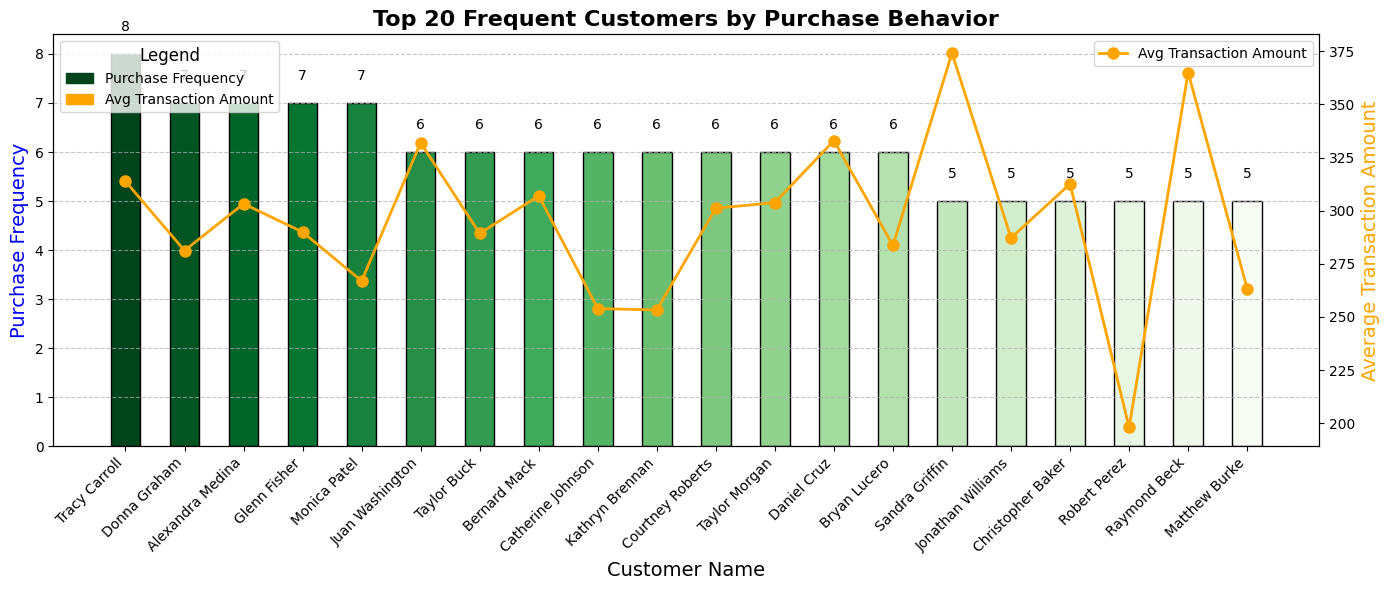

In [37]:
# Join the customer spending data with the customer details to get names and countries
# This step merges customer spending behavior data with customer details to enrich the dataset with customer names and countries.
customer_details_df = customers_df.select("Customer_ID", "Name", "Country")
customer_behavior_df = customer_spending_df.join(customer_details_df, on="Customer_ID", how="inner")

# Identify top 20 most active customers based on purchase frequency
# Sorting the merged dataset by purchase frequency to identify the top 10 customers who have made the most purchases.
top_active_customers_df = customer_behavior_df.orderBy(col("Purchase_Frequency").desc()).limit(20)
top_active_customers_pd_df = top_active_customers_df.toPandas()

logger.info("Top 20 Frequent Customers by Purchase Behavior")

# Call the existing function with your data
plot_dual_axis_bar_line(
    data_pd=top_active_customers_pd_df,        # Data for the plot
    x_labels='Name',                           # Column for customer names (x-axis)
    bar_col='Purchase_Frequency',              # Column for bar values (purchase frequency)
    line_col='Average_Transaction_Amount',     # Column for line values (average transaction amount)
    bar_label='Purchase Frequency',            # Label for bar plot
    line_label='Avg Transaction Amount',       # Label for line plot
    title='Top 20 Frequent Customers by Purchase Behavior',  # Plot title
    x_title='Customer Name',                   # x-axis label
    bar_y_title='Purchase Frequency',          # y-axis label for bars
    line_y_title='Average Transaction Amount', # y-axis label for line
    cmap='Greens',                              # Colormap for bars
    line_color='orange',                       # Line color
    figsize=(14, 6),                           # Figure size
    rotation=45                                # Rotation for x-axis labels
)

## 2. Top 20 spending customers with Average Transaction Amount

2024-09-17 07:43:35,524 - logger - INFO - Top 20 Spending Customers with Average Transaction Amount


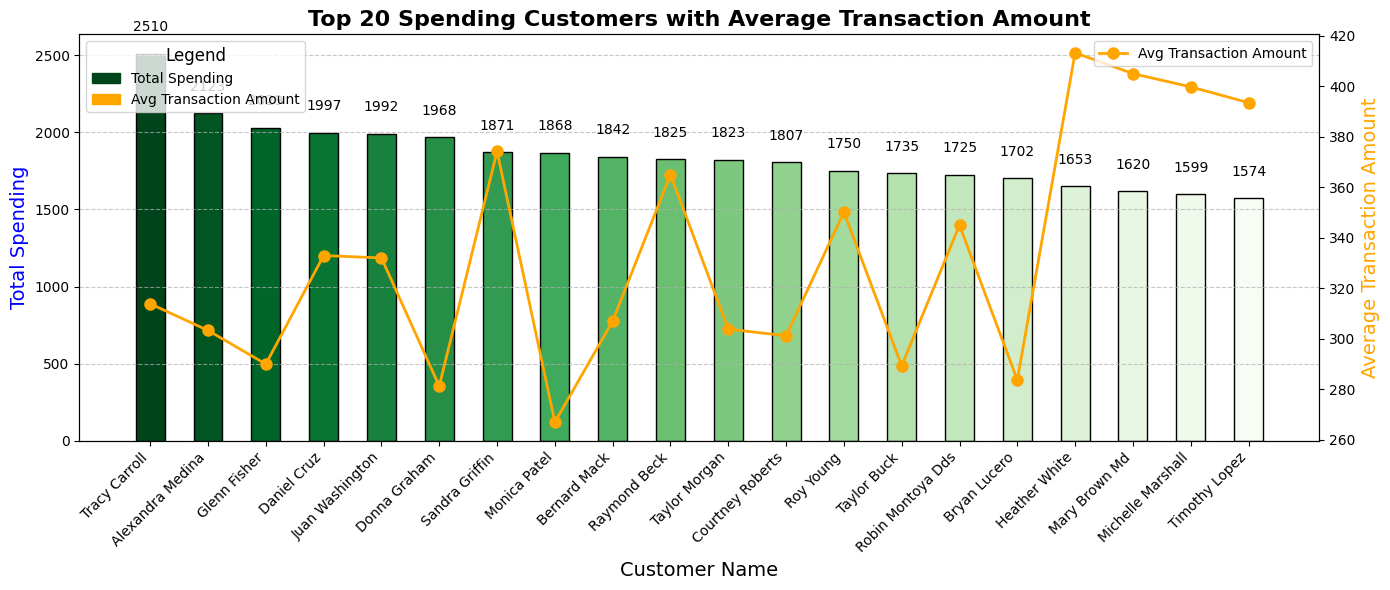

In [44]:
# Join the aggregated spending data with customer details to enrich the dataset
customer_details_df = customers_df.select("Customer_ID", "Name", "Country")
customer_spending_with_details_df = customer_spending_df.join(
    customer_details_df,
    on="Customer_ID",
    how="inner"
)

# Identify top 20 customers based on total spending
top_customers_df = customer_spending_with_details_df.orderBy(col("Total_Spending").desc()).limit(20)
top_customers_pd_df = top_customers_df.toPandas()
logger.info("Top 20 Spending Customers with Average Transaction Amount")

# Call the existing function with your data
plot_dual_axis_bar_line(
    data_pd=top_customers_pd_df,                # Data for the plot
    x_labels='Name',                            # Column for customer names (x-axis)
    bar_col='Total_Spending',                   # Column for bar values (total spending)
    line_col='Average_Transaction_Amount',      # Column for line values (average transaction amount)
    bar_label='Total Spending',                 # Label for bar plot
    line_label='Avg Transaction Amount',        # Label for line plot
    title='Top 20 Spending Customers with Average Transaction Amount',  # Plot title
    x_title='Customer Name',                    # x-axis label
    bar_y_title='Total Spending',               # y-axis label for bars
    line_y_title='Average Transaction Amount',  # y-axis label for line
    cmap='Greens',                               # Colormap for bars
    line_color='orange',                        # Line color
    figsize=(14, 6),                            # Figure size
    rotation=45                                 # Rotation for x-axis labels
)

## 3. Spending Distribution by Country

In [39]:
# Aggregate spending by country and round both the total spending and average transaction amount to 2 decimal points
# This step summarizes the spending data by country, providing rounded figures for easier interpretation and consistency.
country_spending_df = customer_behavior_df.groupBy("Country") \
    .agg(
        sum("Total_Spending").alias("Total_Spending_By_Country"),  # Calculate and round total spending per country
        avg("Average_Transaction_Amount").alias("Avg_Transaction_Amount_By_Country"),  # Calculate and round average transaction amount per country
        count("Customer_ID").alias("Customer_Count_By_Country")  # Count the number of customers per country
    )

# Display the results
# Order by total spending in descending order to see which countries have the highest total spending.
# The results are then shown to provide a clear view of spending distribution by country.
logger.info("Aggregated Spending Data by Country: Total Spending, Avg Transaction Amount, Customer Count")
country_spending_df = country_spending_df.orderBy(col("Total_Spending_By_Country").desc())
country_spending_df.orderBy(col("Customer_Count_By_Country").desc()).show(5)

2024-09-17 07:43:19,474 - logger - INFO - Aggregated Spending Data by Country: Total Spending, Avg Transaction Amount, Customer Count


+-------------------+-------------------------+---------------------------------+-------------------------+
|            Country|Total_Spending_By_Country|Avg_Transaction_Amount_By_Country|Customer_Count_By_Country|
+-------------------+-------------------------+---------------------------------+-------------------------+
|Trinidad And Tobago|       2469.7799999999997|                286.2377777777778|                        6|
|              Congo|                   3668.0|               293.31111111111113|                        6|
|              Spain|                   2455.0|                           228.08|                        5|
|              Macao|                   5187.0|               269.18666666666667|                        5|
|           Barbados|       3378.7799999999997|               275.22799999999995|                        5|
+-------------------+-------------------------+---------------------------------+-------------------------+
only showing top 5 rows



# 4. Top 20 Countries by Number of Customers, Total Spending, and Avg Transaction Amount

2024-09-17 07:43:20,072 - logger - INFO - Top 20 Countries by Number of Customers, Total Spending, and Avg Transaction Amount


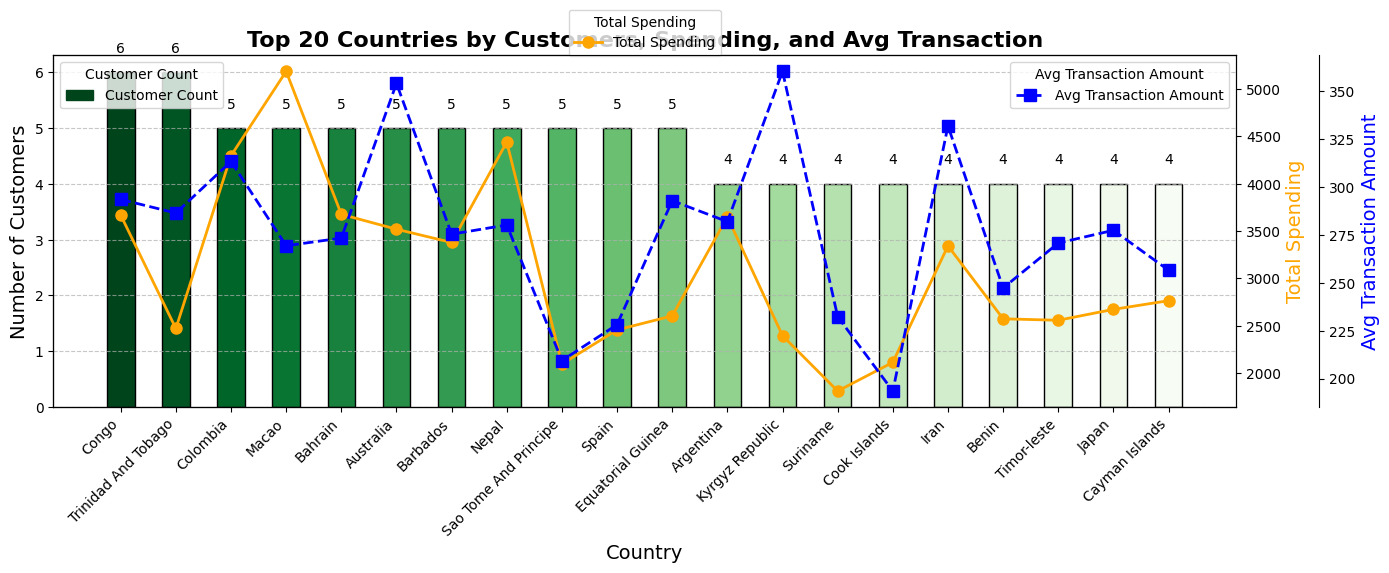

In [40]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
country_spending_pd_df = country_spending_df.toPandas()

# Sorting data to focus on the top 20 countries with the highest customer counts for detailed analysis.
top_countries_df = country_spending_pd_df.sort_values(by="Customer_Count_By_Country", ascending=False).head(20)
logger.info("Top 20 Countries by Number of Customers, Total Spending, and Avg Transaction Amount")

# Use the function to plot top countries by number of customers, total spending, and average transaction amount
plot_triple_axis_bar_line(
    data_pd=top_countries_df,                         # Data for the plot
    x_labels='Country',                               # Column for countries (x-axis)
    bar_col='Customer_Count_By_Country',              # Column for the bar plot (customer count)
    line1_col='Total_Spending_By_Country',            # Column for the first line plot (total spending)
    line2_col='Avg_Transaction_Amount_By_Country',    # Column for the second line plot (avg transaction amount)
    bar_label='Customer Count',                       # Label for the bar plot
    line1_label='Total Spending',                     # Label for the first line plot
    line2_label='Avg Transaction Amount',             # Label for the second line plot
    title='Top 20 Countries by Customers, Spending, and Avg Transaction',  # Plot title
    x_title='Country',                                # x-axis label
    bar_y_title='Number of Customers',                # y-axis label for bars
    line1_y_title='Total Spending',                   # y-axis label for first line plot
    line2_y_title='Avg Transaction Amount',           # y-axis label for second line plot
    cmap='Greens',                                     # Colormap for bars
    line1_color='orange',                             # Color for the first line plot
    line2_color='blue',                              # Color for the second line plot
    figsize=(14, 6),                                  # Figure size
    rotation=45                                       # Rotation for x-axis labels
)



# 5. Grouping Customers based on their spending behaviour

2024-09-17 07:43:20,538 - logger - INFO - Customer Segmentation by Spending Behaviour
2024-09-17 07:43:21,422 - logger - INFO - Customer Count by Cluster


        Cluster_Name  Total_Customers
0  Moderate Spending              181
1      High Spending               53
2       Low Spending              193


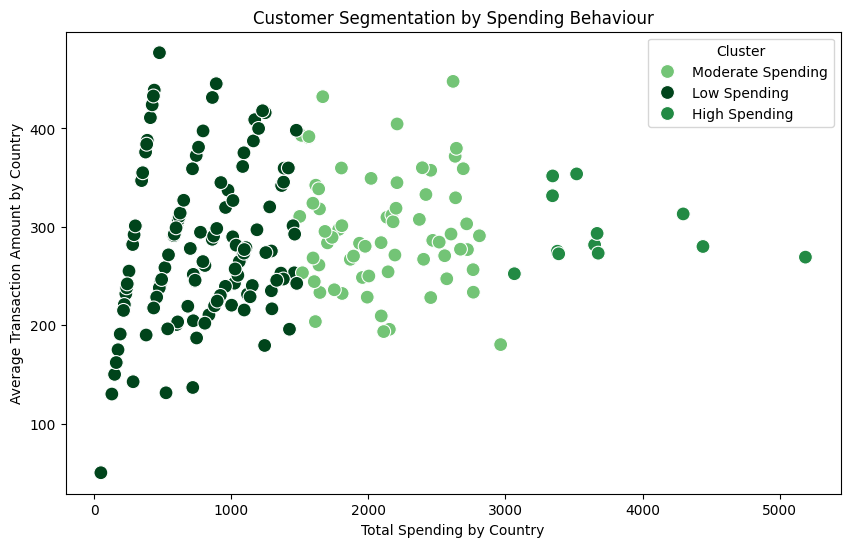

In [41]:

logger.info('Customer Segmentation by Spending Behaviour')

# Step 1: Join transactions with customers to get customer details
transactions_customers_df = transactions_df.join(customers_df, on="Customer_ID", how="inner")

# Step 2: Aggregate data to calculate total spending and average transaction amount per customer
customer_aggregation_df = transactions_customers_df.groupBy("Customer_ID", "Name", "Country") \
    .agg(
        F.sum("Amount").alias("Total_Spending"),
        F.avg("Amount").alias("Average_Transaction_Amount")
    )

# Step 3: Create `customer_spending_with_details_df` by joining with the original customer details
customer_spending_with_details_df = customer_aggregation_df.join(customers_df.select("Customer_ID", "Email", "Phone"), on="Customer_ID", how="inner")

# Step 4: Calculate Total Spending, Average Transaction Amount, and Customer Count by Country
country_aggregation_df = customer_spending_with_details_df.groupBy("Country") \
    .agg(
        F.sum("Total_Spending").alias("Total_Spending_By_Country"),
        F.avg("Average_Transaction_Amount").alias("Avg_Transaction_Amount_By_Country"),
        F.count("Customer_ID").alias("Customer_Count_By_Country")
    )

# Step 5: Manually Define Spending Clusters
def assign_spending_cluster(total_spending):
    if total_spending < 1500:
        return "Low Spending"
    elif 1500 <= total_spending < 3000:
        return "Moderate Spending"
    else:
        return "High Spending"

assign_spending_cluster_udf = F.udf(assign_spending_cluster, F.StringType())

country_clustered_df = country_aggregation_df.withColumn(
    "Cluster_Name", assign_spending_cluster_udf(F.col("Total_Spending_By_Country"))
)

# Calculate the number of customers in each cluster
customer_count_by_cluster = country_clustered_df.groupBy("Cluster_Name") \
    .agg(F.sum("Customer_Count_By_Country").alias("Total_Customers")) \
    .toPandas()


 # Log the cluster counts
logger.info("Customer Count by Cluster")
print(customer_count_by_cluster)
customer_segmentation_by_spending_behavior(transactions_df, customers_df)



# 6. Top 20 Countries by Number of Orders

2024-09-17 07:51:55,483 - logger - INFO - Top 20 Countries by Total Orders, Total Revenue, and Total Customers


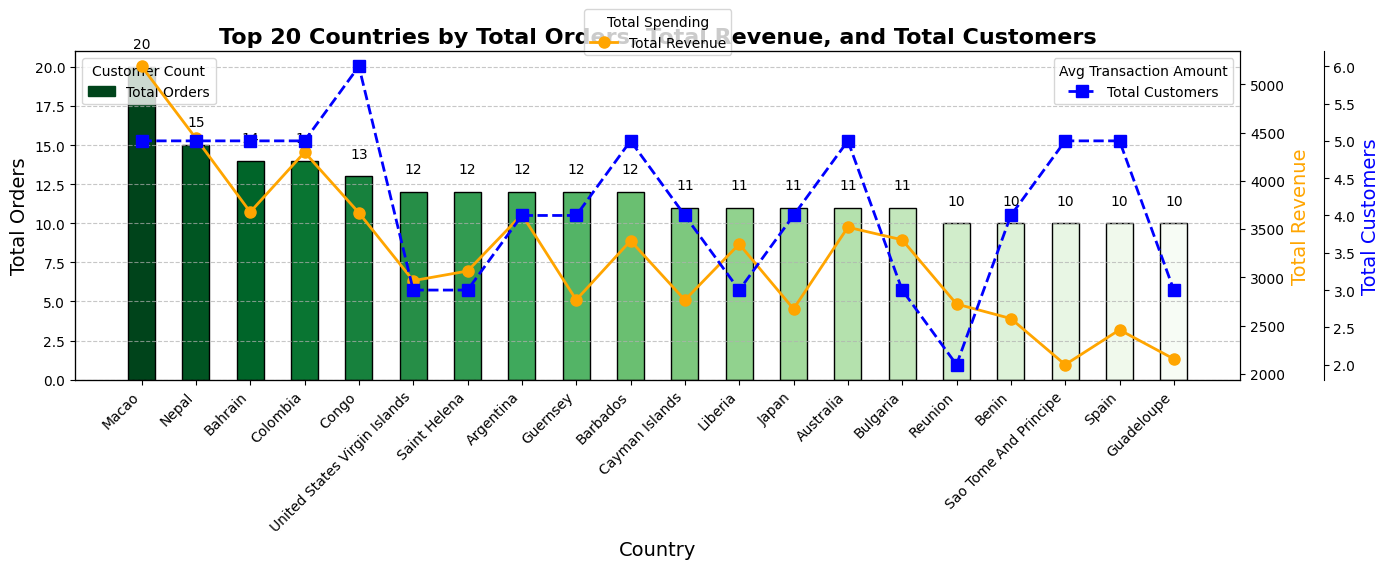

In [45]:
# Step 1: Join transactions with customers to get country information
customer_details_df = customers_df.select("Customer_ID", "Country")
customer_behavior_df = transactions_df.join(customer_details_df, on="Customer_ID", how="inner")

# Step 2: Aggregate the data
country_agg_df = customer_behavior_df.groupBy("Country").agg(
    F.count("Transaction_ID").alias("Total_Orders"),  # Total number of orders
    F.sum("Amount").alias("Total_Revenue"),           # Total revenue (assuming 'Amount' column represents revenue)
    F.countDistinct("Customer_ID").alias("Total_Customers")  # Total number of distinct customers
).orderBy(F.col("Total_Orders").desc())

# Convert to Pandas DataFrame for plotting
country_agg_pd_df = country_agg_df.toPandas()

# Step 3: Sort the data by 'Total_Orders' and take the top 20 countries
top_countries_df = country_agg_pd_df.sort_values(by="Total_Orders", ascending=False).head(20)
logger.info("Top 20 Countries by Total Orders, Total Revenue, and Total Customers")
# Step 5: Call the plot_triple_axis_bar_line function
plot_triple_axis_bar_line(
    data_pd=top_countries_df,
    x_labels='Country',                  # X-axis: Country names
    bar_col='Total_Orders',              # Bar plot: Total Orders
    line1_col='Total_Revenue',           # First line plot: Total Revenue
    line2_col='Total_Customers',         # Second line plot: Total Customers
    bar_label='Total Orders',            # Bar label
    line1_label='Total Revenue',         # Line 1 label
    line2_label='Total Customers',       # Line 2 label
    title='Top 20 Countries by Total Orders, Total Revenue, and Total Customers',  # Plot title
    x_title='Country',                   # X-axis title
    bar_y_title='Total Orders',          # Y-axis title for the bar plot
    line1_y_title='Total Revenue',       # Y-axis title for the first line plot
    line2_y_title='Total Customers',     # Y-axis title for the second line plot
    cmap=get_cmap('Greens'),                           # Colormap for bars
    line1_color='orange',                # Line 1 color (Revenue)
    line2_color='Blue',                 # Line 2 color (Customers)
    figsize=(14, 6),                     # Figure size
    rotation=45                          # Rotation for x-axis labels
)




## 7. Quaterly, Monthly and weekly Trends of Purchasing Behavior

2024-09-17 07:43:24,554 - logger - INFO - Quaterly, Monthly and weekly Trends of Purchasing Behavior


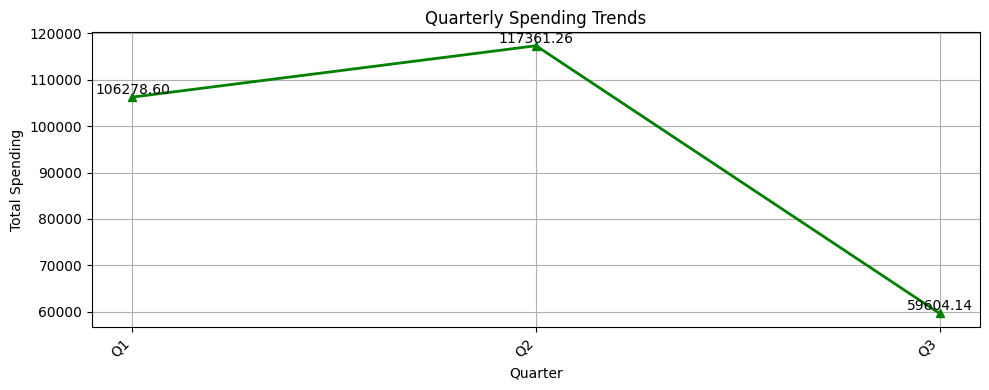

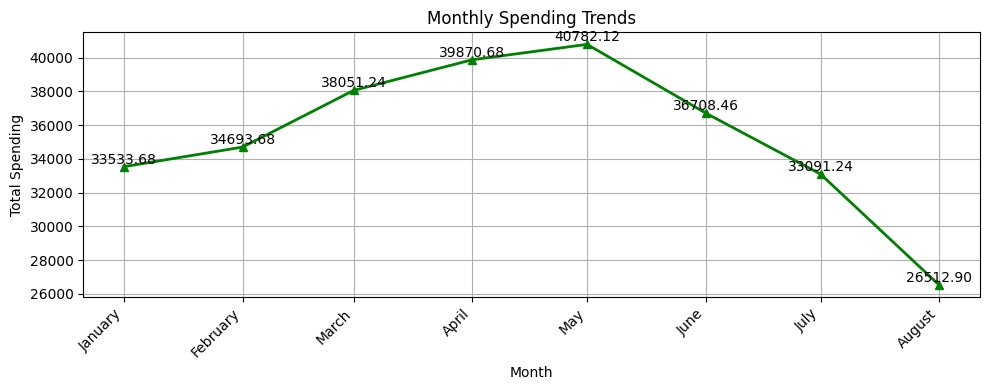

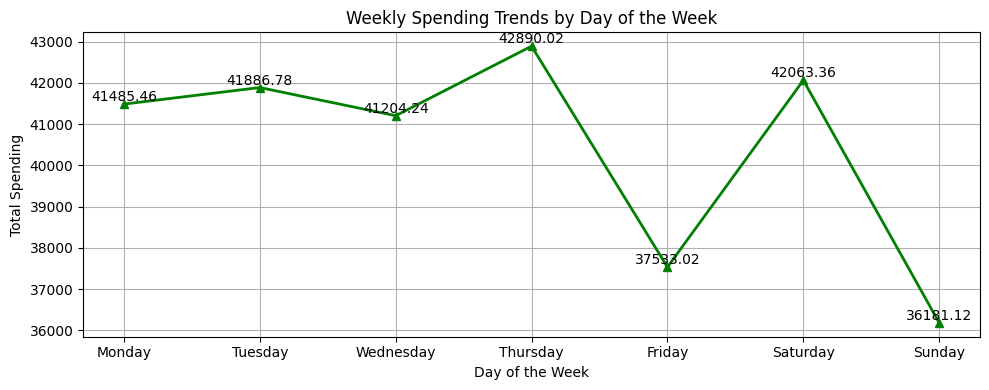

In [43]:
# Convert 'Date' column to date format
transactions_df = transactions_df.withColumn('Date', to_date(col('Date'), 'yyyy-MM-dd'))

# Extract year and month for monthly aggregation
transactions_df = transactions_df.withColumn('Year', F.year(col('Date')))
transactions_df = transactions_df.withColumn('Month', F.month(col('Date')))
transactions_df = transactions_df.withColumn('Month_Name', F.date_format(col('Date'), 'MMMM'))

# Aggregate total spending by year and month
monthly_spending_df = transactions_df.groupBy("Year", "Month", "Month_Name").agg(
    F.round(F.sum("Amount"), 2).alias("Total_Spending")
).orderBy("Year", "Month")

# Convert to Pandas DataFrame for plotting
monthly_spending_pd_df = monthly_spending_df.toPandas()

# Assign a default day (e.g., the first of the month)
monthly_spending_pd_df['Date'] = pd.to_datetime(monthly_spending_pd_df[['Year', 'Month']].assign(Day=1))

# Extract year and quarter for quarterly aggregation
transactions_df = transactions_df.withColumn('Quarter', F.quarter(col('Date')))

# Aggregate total spending by year and quarter
quarterly_spending_df = transactions_df.groupBy("Year", "Quarter").agg(
    F.round(F.sum("Amount"), 2).alias("Total_Spending")
).orderBy("Year", "Quarter")

# Convert to Pandas DataFrame for plotting
quarterly_spending_pd_df = quarterly_spending_df.toPandas()

# Assign a default month and day for each quarter (e.g., the first day of the first month in the quarter)
quarterly_spending_pd_df['Date'] = pd.to_datetime(quarterly_spending_pd_df[['Year']].assign(
    Month=quarterly_spending_pd_df['Quarter']*3 - 2, Day=1))

# Extract day of the week for weekly aggregation (7 days of the week)
transactions_df = transactions_df.withColumn('Day_Of_Week', date_format(col('Date'), 'EEEE'))

# Aggregate total spending by day of the week
weekly_spending_df = transactions_df.groupBy("Day_Of_Week").agg(
    F.round(F.sum("Amount"), 2).alias("Total_Spending")
).orderBy(F.expr("case when Day_Of_Week = 'Monday' then 1 " 
                 "when Day_Of_Week = 'Tuesday' then 2 "
                 "when Day_Of_Week = 'Wednesday' then 3 "
                 "when Day_Of_Week = 'Thursday' then 4 "
                 "when Day_Of_Week = 'Friday' then 5 "
                 "when Day_Of_Week = 'Saturday' then 6 "
                 "when Day_Of_Week = 'Sunday' then 7 "
                 "else 8 end"))

# Convert to Pandas DataFrame for plotting
weekly_spending_pd_df = weekly_spending_df.toPandas()
logger.info("Quaterly, Monthly and weekly Trends of Purchasing Behavior")
plot_trend(
    quarterly_spending_pd_df,
    x_col='Date',
    y_col='Total_Spending',
    x_ticks=quarterly_spending_pd_df['Date'],
    x_labels=[f'Q{q}' for q in quarterly_spending_pd_df['Quarter']],
    title='Quarterly Spending Trends',
    xlabel='Quarter',
    ylabel='Total Spending'
)

plot_trend(
    monthly_spending_pd_df,
    x_col='Date',
    y_col='Total_Spending',
    x_ticks=monthly_spending_pd_df['Date'],
    x_labels=monthly_spending_pd_df['Month_Name'],
    title='Monthly Spending Trends',
    xlabel='Month',
    ylabel='Total Spending'
)

plot_trend(
    weekly_spending_pd_df,
    x_col='Day_Of_Week',
    y_col='Total_Spending',
    title='Weekly Spending Trends by Day of the Week',
    xlabel='Day of the Week',
    ylabel='Total Spending',
    x_ticks=None,  # No specific ticks needed for day of the week
    x_labels=None  # Default labels are fine
)

